In [1]:
# Crypto heatmap

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Coinbase"
f = requests.get(url)
ipdata = f.json()
pd.DataFrame(ipdata['Data']).head(5)

,time,close,high,low,open,volumefrom,volumeto
0,1597968000,11529.22,11884.99,11480.00,11864.26,14865.30,1.740847e+08
1,1598054400,11672.93,11693.16,11370.00,11529.22,7946.04,9.158989e+07
2,1598140800,11650.01,11715.00,11525.62,11672.93,5516.16,6.417719e+07
3,1598227200,11753.85,11823.62,11592.91,11650.01,7252.74,8.515630e+07
4,1598313600,11324.92,11769.76,11102.73,11753.85,14348.64,1.637034e+08


In [4]:
def get_data(date):
    """query API for 2000 days historical price data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(
        date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [5]:
def get_df(from_date, to_date):
    date = to_date
    holder = []
    # while earliest date returned is later than the earliest data requested, keep querying API # and adding results to list
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
        # join together all api queries from list
        df = pd.concat(holder, axis=0)
        # remove data points from before from_date
        df = df[df['time'] > from_date]
        # convert to timestamp
        df['time'] = pd.to_datetime(df['time'], unit='s')
        # make datafrom index the time
        df.set_index('time', inplace=True)
        # sort in time order
        df.sort_index(ascending=False, inplace=True)
        return df

In [6]:
df = get_df(1590996893, 1598904900)
df.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2020-08-31,11710.80,11775.27,11586.36,11716.54,22163.82,2.592848e+08
2020-08-30,11716.54,11718.98,11470.07,11480.48,16398.78,1.906494e+08
2020-08-29,11480.48,11585.98,11433.80,11535.21,16305.87,1.877460e+08
2020-08-28,11535.21,11553.81,11289.07,11331.02,30815.36,3.530279e+08
2020-08-27,11331.02,11591.64,11135.52,11466.89,40978.91,4.649572e+08


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


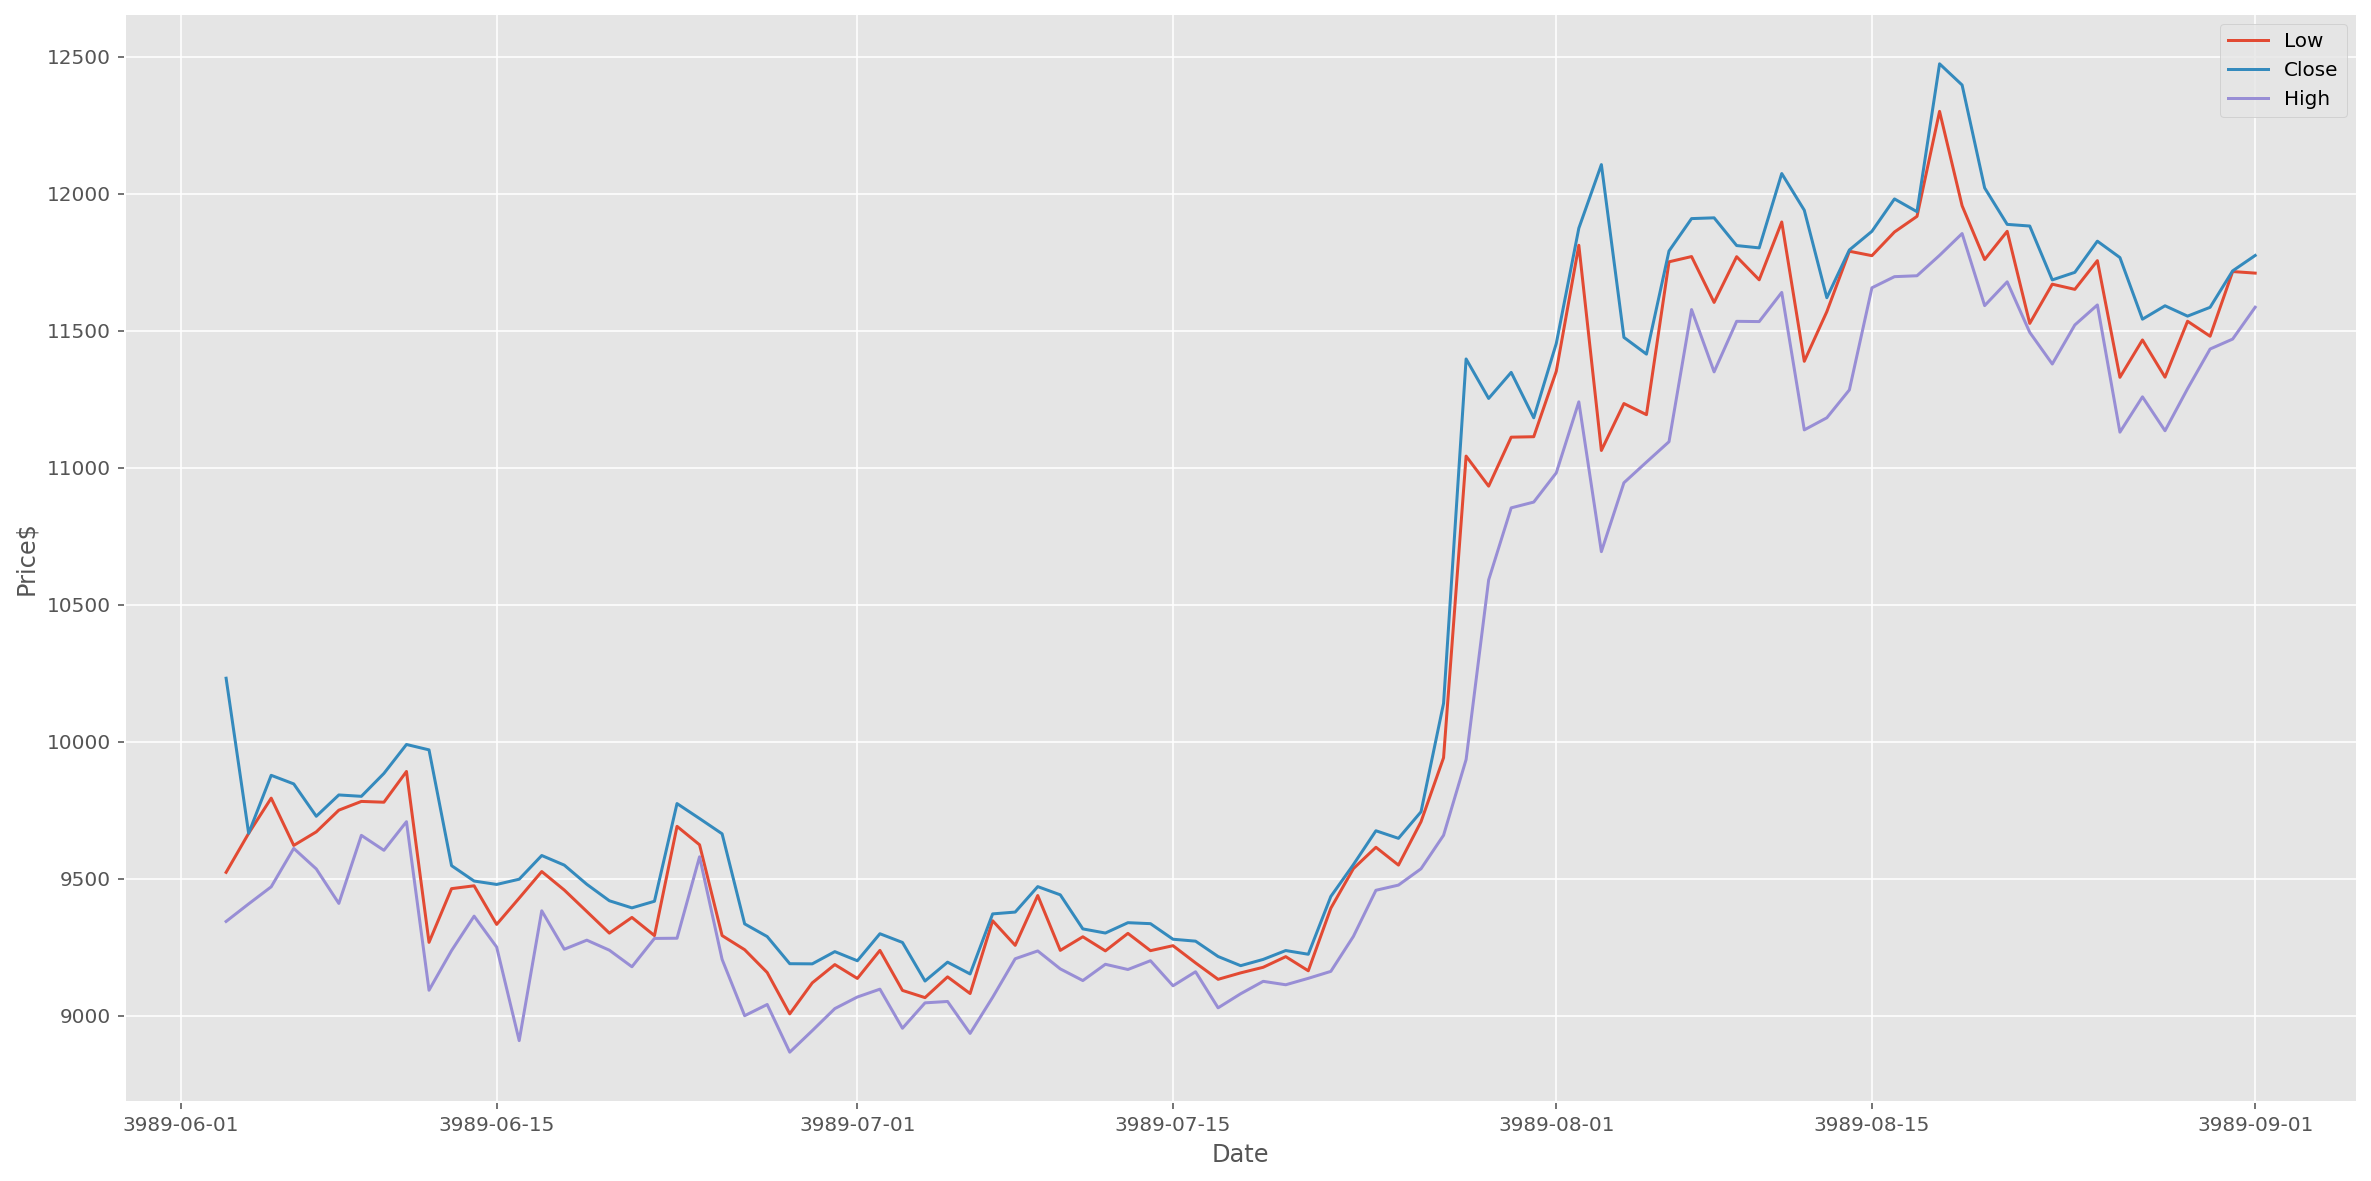

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df[['close', 'high', 'low']])
ax.set_ylabel('Price$')
ax.set_xlabel('Date')
ax.legend(['Low', 'Close', 'High'])
plt.show();

In [8]:
def get_data_spec(coin, date, time_period):
    """query api for historical data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/{}?fsym={}&tsym=USD&Limit=2000&toTs={}".format(
        time_period, coin, date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [9]:
def get_df_spec(time_period, coin, from_date, to_date):
    """ get historical price data between dates. If further apart query multiple times."""
    date = to_date
    holder = []
    while date > from_date:
        data = get_data_spec(coin, date, time_period)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    df = pd.concat(holder, axis=0)
    df = df[df['time'] > from_date]
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    df.sort_index(ascending=False, inplace=True)
    df.rename(columns={'close': coin}, inplace=True)
    return df[coin]

In [10]:
coins = ['BTC', 'ETH', 'LTC', 'XRP', 'EOS', 'ADA', 'XLM', 'TRX', 'ZRX', 'BCH', 'XMR']

In [11]:
holder = []
from_date = 1590996893 #06-01-2020
to_date = 1598904900 #06-24-2020
time_period = 'histoday'

for coin in coins:
    holder.append(get_df_spec(time_period, coin, from_date, to_date))
df = pd.concat(holder, axis=1)

In [12]:
# convert each column of df to be rate of return instead of price
df = df.divide(df.shift()) - 1
df_norm_col = (df - df.mean()) / df.std()

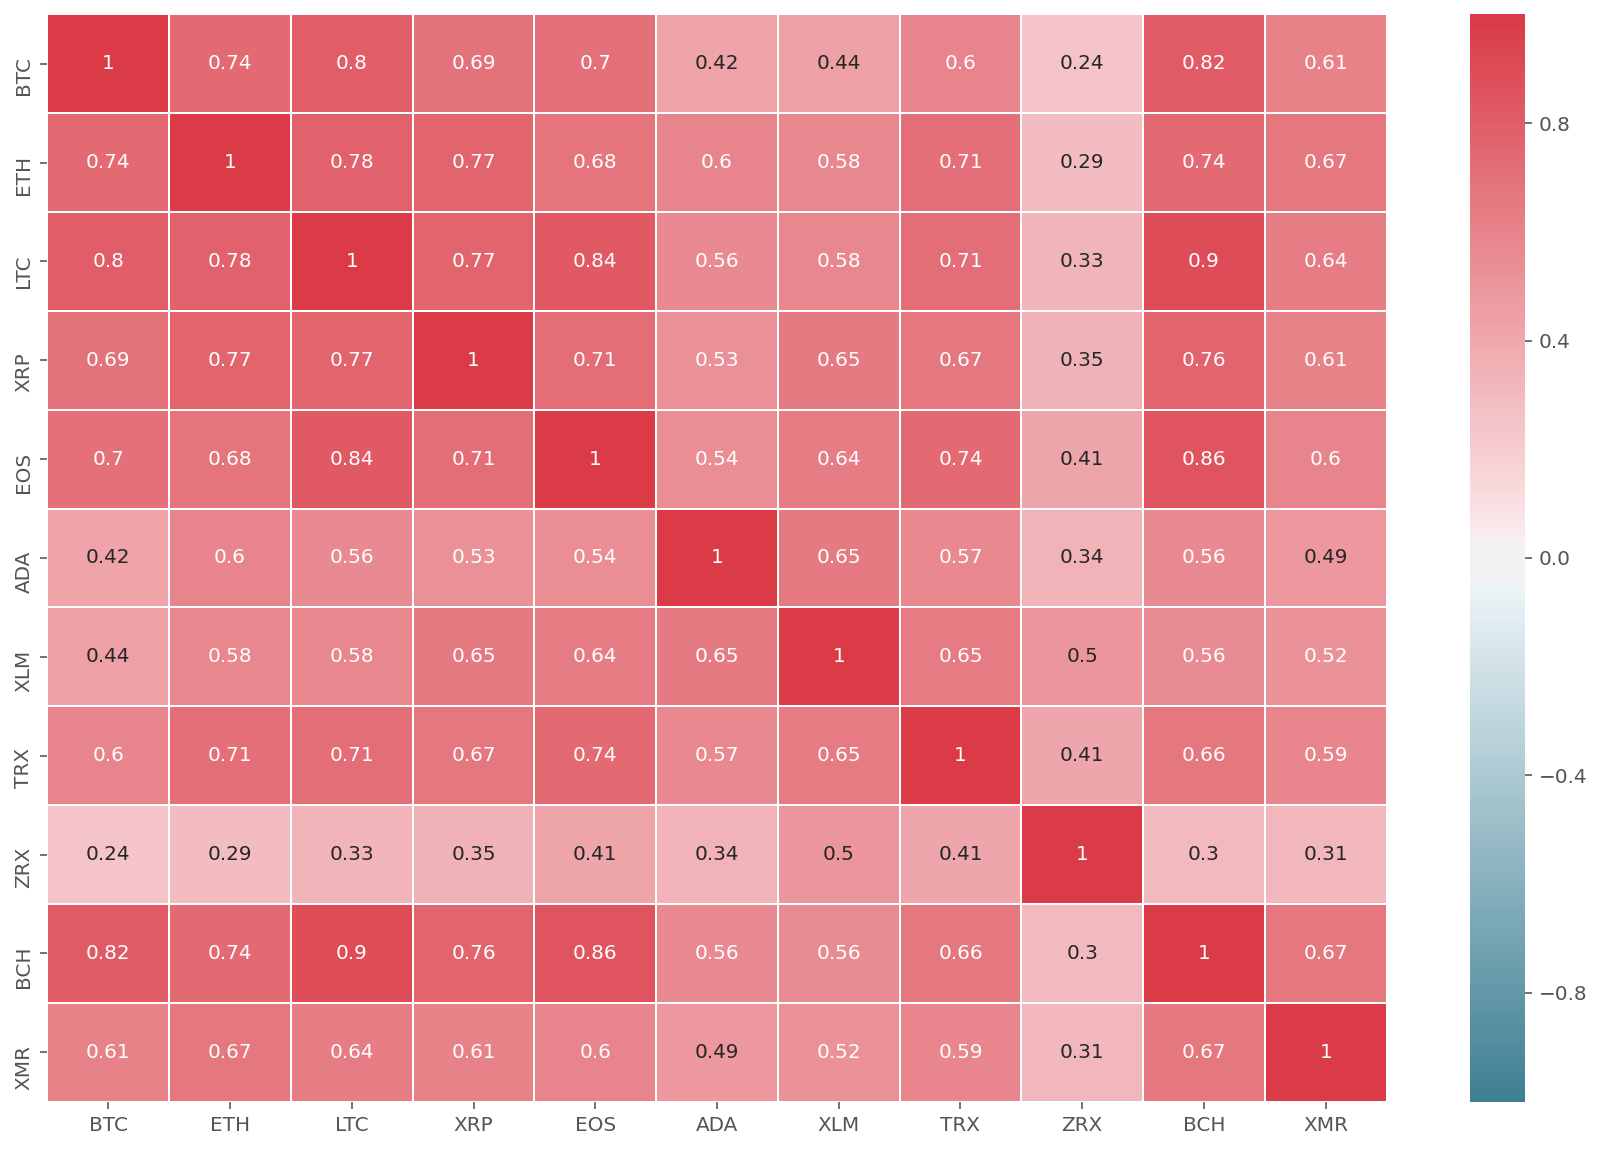

In [13]:
fig = plt.figure(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, linewidth=0.5, cmap=cmap)
plt.show()